In [246]:
import os
import pandas as pd
import numpy as np
import networkx as nx
from datetime import datetime
import math
import random
from node2vec import Node2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1. LOAD & PREPARE DATA

In [84]:
DATA_FOLDER = "data"

# Filenames
ROUTES_FILE     = os.path.join(DATA_FOLDER, "IDFM-gtfs/routes.txt")
TRIPS_FILE      = os.path.join(DATA_FOLDER, "IDFM-gtfs/trips.txt")
STOP_TIMES_FILE = os.path.join(DATA_FOLDER, "IDFM-gtfs/stop_times.txt")
STOPS_FILE      = os.path.join(DATA_FOLDER, "IDFM-gtfs/stops.txt")
TRANSFERS_FILE  = os.path.join(DATA_FOLDER, "IDFM-gtfs/transfers.txt")

# 2. DATA COLLECTION & FILTERING
- Keep only Metro (route_type=1) and RER (route_type=2) lines.
- Identify RER lines by route_short_name or route_id as needed.

In [3]:
# Read each GTFS file into a DataFrame
df_routes     = pd.read_csv(ROUTES_FILE,     dtype=str)
df_trips      = pd.read_csv(TRIPS_FILE,      dtype=str)
df_stop_times = pd.read_csv(STOP_TIMES_FILE, dtype=str)
df_stops      = pd.read_csv(STOPS_FILE,      dtype=str)
df_transfers  = pd.read_csv(TRANSFERS_FILE,  dtype=str)

In [4]:
# Convert numeric columns
for col in ["route_type"]:
    if col in df_routes.columns:
        df_routes[col] = pd.to_numeric(df_routes[col])

for col in ["stop_sequence", "transfer_type", "min_transfer_time"]:
    for df_ in [df_stop_times, df_transfers]:
        if col in df_.columns:
            df_[col] = pd.to_numeric(df_[col])

In [ ]:
# Subset routes for Metro (route_type=1) or Rail (route_type=2) 
# but exclude known Transilien lines and 'TER'
excluded_short_names = {"H", "J", "K", "L", "N", "P", "R", "U", "V", "TER"}

df_routes_sub = df_routes[
    df_routes["route_type"].isin([1, 2]) &
    ~df_routes["route_short_name"].isin(excluded_short_names)
].copy()


In [8]:
# Gather the route_ids to keep
keep_route_ids = set(df_routes_sub["route_id"].unique())

# Filter trips for those route_ids
df_trips_sub = df_trips[df_trips["route_id"].isin(keep_route_ids)].copy()

# Gather the trip_ids to keep
keep_trip_ids = set(df_trips_sub["trip_id"].unique())

# Filter stop_times for those trip_ids
df_stop_times_sub = df_stop_times[df_stop_times["trip_id"].isin(keep_trip_ids)].copy()

# Gather the stop_ids actually used
keep_stop_ids = set(df_stop_times_sub["stop_id"].unique())

# Filter stops for those stop_ids
df_stops_sub = df_stops[df_stops["stop_id"].isin(keep_stop_ids)].copy()

# Reset indices for convenience
df_routes_sub.reset_index(drop=True, inplace=True)
df_trips_sub.reset_index(drop=True, inplace=True)
df_stop_times_sub.reset_index(drop=True, inplace=True)
df_stops_sub.reset_index(drop=True, inplace=True)

# 3. GRAPH CONSTRUCTION

In [95]:
G = nx.Graph()

### 3.1 DEFINE NODES

In [96]:
for _, row in df_stops_sub.iterrows():
    stop_id = row["stop_id"]
    stop_name = row.get("stop_name", "")
    lat = float(row["stop_lat"]) if pd.notna(row["stop_lat"]) else None
    lon = float(row["stop_lon"]) if pd.notna(row["stop_lon"]) else None

    G.add_node(stop_id,
               stop_name=stop_name,
               stop_lat=lat,
               stop_lon=lon)

### 3.2 DEFINE EDGES FROM STOP_TIMES

In [97]:
# For each trip, link consecutive stops, and store travel time.

# Convert arrival_time / departure_time to seconds so we can compute durations
def hhmmss_to_seconds(t_str):
    """Convert 'HH:MM:SS' to integer seconds, or None if missing."""
    if pd.isna(t_str):
        return None
    parts = t_str.split(":")
    if len(parts) != 3:
        return None
    h, m, s = parts
    return int(h)*3600 + int(m)*60 + int(s)

if "arrival_time" in df_stop_times_sub.columns:
    df_stop_times_sub["arrival_sec"] = df_stop_times_sub["arrival_time"].apply(hhmmss_to_seconds)
if "departure_time" in df_stop_times_sub.columns:
    df_stop_times_sub["departure_sec"] = df_stop_times_sub["departure_time"].apply(hhmmss_to_seconds)

In [98]:
# Build mapping: route_id -> route_short_name (from df_routes_sub)
route_to_short = dict(zip(df_routes_sub["route_id"], df_routes_sub["route_short_name"]))

# Now build mapping: trip_id -> route_short_name (line)
trip_to_line = {}
for _, row in df_trips_sub.iterrows():
    trip_id = row["trip_id"]
    route_id = row["route_id"]
    trip_to_line[trip_id] = route_to_short.get(route_id, None)

# Build rail edges for each trip, assigning line info to edges
grouped = df_stop_times_sub.sort_values(["trip_id", "stop_sequence"]).groupby("trip_id")

for trip_id, group in grouped:
    # Look up the line name for this trip
    trip_line = trip_to_line.get(trip_id, None)
    
    # Get list of stops and compute arrival/departure times
    stop_ids = group["stop_id"].tolist()
    arrivals = group.get("arrival_sec", None)
    departs  = group.get("departure_sec", None)

    # Link consecutive stops
    for i in range(len(stop_ids) - 1):
        from_stop = stop_ids[i]
        to_stop   = stop_ids[i+1]

        # Compute travel_time as weight, fallback if negative/zero
        travel_time = None
        if arrivals is not None and departs is not None:
            arr_next = arrivals.iloc[i+1]
            dep_curr = departs.iloc[i]
            if pd.notna(arr_next) and pd.notna(dep_curr):
                travel_time = arr_next - dep_curr
                if travel_time <= 0:
                    travel_time = None

        # Add or update edge with line info:
        if not G.has_edge(from_stop, to_stop):
            G.add_edge(from_stop, to_stop, weight=travel_time, type="rail", line=trip_line)
        else:
            # If edge exists, update its 'line' attribute to include this trip's line if not already present.
            current_line = G[from_stop][to_stop].get("line")
            if current_line is None:
                G[from_stop][to_stop]["line"] = trip_line
            else:
                # If it's a string and not equal to trip_line, convert to list
                if isinstance(current_line, str):
                    if current_line != trip_line:
                        G[from_stop][to_stop]["line"] = [current_line, trip_line]
                elif isinstance(current_line, list):
                    if trip_line not in current_line:
                        current_line.append(trip_line)


### 3.3 MERGE CHILD AND PARENT NODES (for multi-lines stations)

In [99]:
# Build a dictionary: merged_map[child_stop] = parent_stop
# or if no parent, point to itself.
merged_map = {}

for _, row in df_stops_sub.iterrows():
    stop_id = row["stop_id"]
    parent_station = row.get("parent_station", None)
    
    if parent_station and pd.notna(parent_station):
        # Child -> parent
        merged_map[stop_id] = parent_station
    else:
        # No parent => keep as is
        merged_map[stop_id] = stop_id

# Merge child stops into parent stations in-place:
nx.relabel_nodes(G, merged_map, copy=False)


### 3.5 Final check

In [100]:
print(f"Number of nodes in G: {G.number_of_nodes()}")
print(f"Number of edges in G: {G.number_of_edges()}")

# Example: Inspect a random node
some_node = list(G.nodes)[0]
print("Example node attributes:", G.nodes[some_node])

# Example: Inspect a random edge
some_edge = list(G.edges)[0]
print("Example edge data:", G.edges[some_edge])


Number of nodes in G: 546
Number of edges in G: 678
Example node attributes: {'stop_name': 'Achères Ville', 'stop_lat': 48.970643570814424, 'stop_lon': 2.0777265246565433}
Example edge data: {'weight': 330, 'type': 'rail', 'line': 'A'}


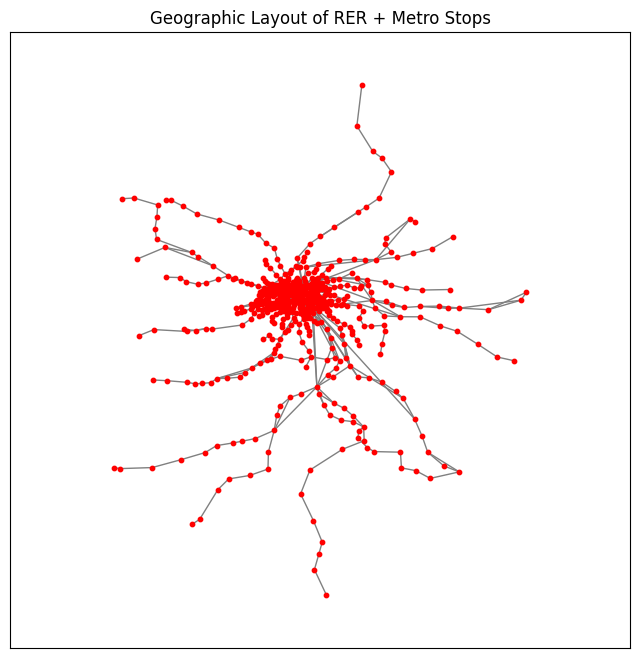

In [101]:
import matplotlib.pyplot as plt
import networkx as nx

# Build a "pos" dict: node -> (lon, lat)
pos = {}
for node in G.nodes():
    lat = G.nodes[node].get("stop_lat")
    lon = G.nodes[node].get("stop_lon")
    if lat is not None and lon is not None:
        # Typically, x=longitude, y=latitude
        pos[node] = (lon, lat)

# Filter out nodes that have no coordinates
sub_nodes = list(pos.keys())
H = G.subgraph(sub_nodes)

plt.figure(figsize=(8, 8))
nx.draw_networkx(
    H,
    pos=pos,
    with_labels=False,
    node_size=10,
    node_color="red",
    edge_color="gray"
)
plt.title("Geographic Layout of RER + Metro Stops")
plt.axis("equal")  # so lat-lon scale isn't skewed
plt.show()


### Exporting the network graph in a more interpretable way
Just open the html file generated
- Can zoom in / out
- Colored lines
- Station names

In [ ]:
import matplotlib.pyplot as plt
from pyvis.network import Network
from IPython.display import IFrame

# Scale and assign x, y positions based on lat/lon

# Gather latitudes and longitudes from nodes that have them
lons = [G.nodes[n]['stop_lon'] for n in G.nodes() if G.nodes[n].get('stop_lon') is not None]
lats = [G.nodes[n]['stop_lat'] for n in G.nodes() if G.nodes[n].get('stop_lat') is not None]

# Compute min and max to shift coordinates
min_lon, max_lon = min(lons), max(lons)
min_lat, max_lat = min(lats), max(lats)

# Choose a scaling factor to spread out the nodes (adjust as needed)
scale = 20000

for n in G.nodes():
    lon = G.nodes[n].get('stop_lon')
    lat = G.nodes[n].get('stop_lat')
    if lon is not None and lat is not None:
        x = (lon - min_lon) * scale
        y = (max_lat - lat) * scale
        G.nodes[n]['x'] = x
        G.nodes[n]['y'] = y


# Convert any list-type "line" attributes to a single string

for u, v, data in G.edges(data=True):
    line_attr = data.get("line")
    if isinstance(line_attr, list):
        # If multiple lines, pick the first one or join them (happens on only 3 edges). Here we pick the first.
        data["line"] = line_attr[0]


# Create and configure the PyVis network

net = Network(height='750px', width='100%', notebook=True, directed=False)
net.toggle_physics(False)  # disable physics to fix positions

# Import the NetworkX graph G into PyVis

net.from_nx(G)


# Fix node positions and set labels

for node in net.nodes:
    node['fixed'] = {'x': True, 'y': True}
    node_id = node["id"]
    station_name = G.nodes[node_id].get("stop_name", str(node_id))
    node["label"] = station_name


# Set edge colors based on the "line" attribute

# Mapping from line names to colors
line_colors = {
    "A": "#F7403A", "B": "#4B92DB", "C": "#F3D311", "D": "#3F9C35", "E": "#DE81D3", "1": "#FFCE00", "2": "#0064B0", "3": "#9F9825", "3B": "#98D4E2", "4": "#C04191", "5": "#F28E42", "6": "#83C491", "7": "#F3A4BA", "7B": "#83C491", "8": "#CEADD2", "9": "#D5C900", "10": "#E3B32A", "11": "#8D5E2A", "12": "#00814F", "13": "#98D4E2", "14": "#662483", "15": "#B90845", "16": "#F3A4BA", "17": "#D5C900", "18": "#00A88F"
}

for edge in net.edges:
    line_attr = edge.get("line")
    if line_attr and line_attr in line_colors:
        edge["color"] = line_colors[line_attr]
    else:
        edge["color"] = "#888888"

# Display the network

net.show("idf_graph_named.html");


idf_graph_named.html


# 4. FEATURE ENGINEERING

In [111]:
# Structural Features

# Node degree: add as a node attribute
for node in G.nodes():
    G.nodes[node]["degree"] = G.degree(node)

# Clustering coefficient: using NetworkX's clustering function
clust_dict = nx.clustering(G)
for node, clust in clust_dict.items():
    G.nodes[node]["clustering"] = clust

# Betweenness centrality: using NetworkX's betweenness_centrality
btwn_dict = nx.betweenness_centrality(G)
for node, btw in btwn_dict.items():
    G.nodes[node]["betweenness"] = btw


In [112]:
# Geographical Features: Compute physical distances between nodes

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points 
    on the Earth specified by latitude and longitude.
    Returns distance in kilometers.
    """
    R = 6371  # Radius of Earth in km
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)
    a = math.sin(delta_phi/2.0)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(delta_lambda/2.0)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

# For each edge, compute the distance based on the nodes' lat/lon.
for u, v, data in G.edges(data=True):
    lat_u = G.nodes[u].get("stop_lat")
    lon_u = G.nodes[u].get("stop_lon")
    lat_v = G.nodes[v].get("stop_lat")
    lon_v = G.nodes[v].get("stop_lon")
    
    if None not in (lat_u, lon_u, lat_v, lon_v):
        data["distance"] = haversine_distance(lat_u, lon_u, lat_v, lon_v)
    else:
        data["distance"] = None

In [113]:
# Edge Attributes: Verify travel time and "line" attribute

for u, v, data in G.edges(data=True):
    # Ensure travel time (weight) is set; if missing, assign a default value (e.g., 60 seconds)
    if "weight" not in data or data["weight"] is None:
        data["weight"] = 60  # Default travel time in seconds
    
    # Ensure the "line" attribute exists; if missing, assign a default string
    if "line" not in data:
        data["line"] = "Unknown"

# Optionally, print out summary statistics
print("Structural Features computed:")
print(" - Average node degree:", sum(G.nodes[n]["degree"] for n in G.nodes())/G.number_of_nodes())
print(" - Sample node clustering:", list(clust_dict.items())[:5])
print(" - Sample node betweenness:", list(btwn_dict.items())[:5])

edge_distances = [data["distance"] for u, v, data in G.edges(data=True) if data["distance"] is not None]
if edge_distances:
    print("Average edge distance (km):", sum(edge_distances)/len(edge_distances))


Structural Features computed:
 - Average node degree: 2.4835164835164836
 - Sample node clustering: [('IDFM:73604', 0), ('IDFM:63029', 0), ('IDFM:412697', 0.3333333333333333), ('IDFM:474151', 0), ('IDFM:68916', 0)]
 - Sample node betweenness: [('IDFM:73604', 0.018213707501349163), ('IDFM:63029', 2.361036157582299e-05), ('IDFM:412697', 0.025404749055585537), ('IDFM:474151', 0.387362023604365), ('IDFM:68916', 0.003669724770642202)]
Average edge distance (km): 1.7490129902218852


# 5. CREATING TRAINING AND TEST SETS

In [ ]:
# Extract Positive Edges

# Get all positive edges from the complete graph G
positive_edges = list(G.edges())
num_edges = len(positive_edges)
print("Total number of positive edges:", num_edges)

# Determine number of test edges (20% of total)
num_test = int(0.2 * num_edges)
print("Number of test positive edges:", num_test)

# Randomly sample 20% of positive edges for the test set
test_positive_edges = random.sample(positive_edges, num_test)
# The remaining edges will be used as positive training examples
train_positive_edges = [edge for edge in positive_edges if edge not in test_positive_edges]


Total number of positive edges: 678
Number of test positive edges: 135
Number of edges in training graph: 543


In [141]:
# Create Training Graph G_train

G_train = G.copy()
G_train.remove_edges_from(test_positive_edges)
print("Number of edges in training graph:", G_train.number_of_edges())

Number of edges in training graph: 543


In [168]:
# Generate Negative Examples (only for node pairs within 7 km for realism)

nodes = list(G_train.nodes())

def sample_negative_edges(num_samples, graph, nodes_list, max_distance=5):
    """
    Randomly sample num_samples negative edges (pairs of nodes that are not connected)
    from the graph, but only consider pairs where the geographical distance (based on
    stop_lat and stop_lon attributes) is within max_distance (in km).
    """
    neg_edges = set()
    while len(neg_edges) < num_samples:
        u, v = random.sample(nodes_list, 2)
        # Ensure the pair is not connected in the training graph
        if not graph.has_edge(u, v) and (u, v) not in neg_edges and (v, u) not in neg_edges:
            lat_u = graph.nodes[u].get("stop_lat")
            lon_u = graph.nodes[u].get("stop_lon")
            lat_v = graph.nodes[v].get("stop_lat")
            lon_v = graph.nodes[v].get("stop_lon")
            # Check that coordinates exist for both nodes
            if None in (lat_u, lon_u, lat_v, lon_v):
                continue
            distance = haversine_distance(lat_u, lon_u, lat_v, lon_v)
            if distance <= max_distance:
                neg_edges.add((u, v))
    return list(neg_edges)

# Number of negative examples should match the number of positive examples
num_train_neg = len(train_positive_edges)
num_test_neg = len(test_positive_edges)

train_negative_edges = sample_negative_edges(num_train_neg, G_train, nodes, max_distance=7)
test_negative_edges = sample_negative_edges(num_test_neg, G_train, nodes, max_distance=7)


In [169]:
# Create Train/Test Sets with Labels


train_set = [(u, v, 1) for u, v in train_positive_edges] + [(u, v, 0) for u, v in train_negative_edges]
# Create test set similarly
test_set = [(u, v, 1) for u, v in test_positive_edges] + [(u, v, 0) for u, v in test_negative_edges]

# Shuffle the sets
random.shuffle(train_set)
random.shuffle(test_set)

print("Training set size:", len(train_set))
print("Test set size:", len(test_set))


Training set size: 1086
Test set size: 270


# 6. MODELS

### 6.1 Heuristic Scores (Baselines)

In [170]:
# Create a list of test pairs (without the label)
test_pairs = [(u, v) for u, v, label in test_set]

# Common Neighbors: compute the number of common neighbors
common_neighbors_scores = { (u, v): len(list(nx.common_neighbors(G_train, u, v))) for u, v in test_pairs }

# Jaccard Coefficient: use the built-in function
jaccard_scores = { (u, v): score for u, v, score in nx.jaccard_coefficient(G_train, test_pairs) }

# Adamic–Adar Index: built-in function
adamic_scores = { (u, v): score for u, v, score in nx.adamic_adar_index(G_train, test_pairs) }

# Preferential Attachment: built-in function
pref_attachment_scores = { (u, v): score for u, v, score in nx.preferential_attachment(G_train, test_pairs) }

# Sort jaccard_scores by score in descending order
sorted_jaccard = sorted(jaccard_scores.items(), key=lambda x: x[1], reverse=True)

print("Top 5 Jaccard Scores (with stop names):")
for i in range(5):
    (u, v), score = sorted_jaccard[i]
    stop_name_u = G.nodes[u].get("stop_name", u)
    stop_name_v = G.nodes[v].get("stop_name", v)
    print(f"Edge: {u} ({stop_name_u}) - {v} ({stop_name_v}), Score = {score:.4f}")


Top 5 Jaccard Scores (with stop names):
Edge: IDFM:70064 (Les Ardoines) - IDFM:69852 (Choisy-le-Roi), Score = 0.6000
Edge: IDFM:71169 (Porte d'Auteuil) - IDFM:73658 (Michel-Ange - Molitor), Score = 0.5000
Edge: IDFM:73190 (Neuilly-Plaisance) - IDFM:73166 (Bry-sur-Marne), Score = 0.5000
Edge: IDFM:72421 (Pantin) - IDFM:72041 (Noisy-le-Sec), Score = 0.3333
Edge: IDFM:71911 (Pré-Saint-Gervais) - IDFM:71906 (Botzaris), Score = 0.3333


### 6.2 Node Embedding Approach (using node2vec)

In [ ]:
# Create the node2vec model from G_train.
node2vec = Node2Vec(G_train, dimensions=256, walk_length=60, num_walks=800, 
                    workers=10, weight_key="weight", seed=42)

# Fit the model to generate embeddings.
model = node2vec.fit(window=10, min_count=1, batch_words=4)

def create_feature_vector(u, v, model):
    """
    Create a feature vector for edge (u,v) by concatenating their embeddings.
    Ensure that the keys are strings as stored in the model.
    """
    emb_u = np.array(model.wv[str(u)])
    emb_v = np.array(model.wv[str(v)])
    return np.concatenate([emb_u, emb_v])

# Build training feature matrix and labels from train_set
X_train = []
y_train = []
for (u, v, label) in train_set:
    try:
        feature = create_feature_vector(u, v, model)
        X_train.append(feature)
        y_train.append(label)
    except KeyError:
        # If a node is missing from the embedding dictionary, skip this edge.
        continue

X_train = np.array(X_train)
y_train = np.array(y_train)

# Build test feature matrix and labels from test_set
X_test = []
y_test = []
for (u, v, label) in test_set:
    try:
        feature = create_feature_vector(u, v, model)
        X_test.append(feature)
        y_test.append(label)
    except KeyError:
        continue

X_test = np.array(X_test)
y_test = np.array(y_test)

# Train a logistic regression classifier on the training features
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(X_train, y_train)




Computing transition probabilities:   0%|          | 0/546 [00:00<?, ?it/s]

Generating walks (CPU: 9): 100%|██████████| 80/80 [00:05<00:00, 15.62it/s]


LogisticRegression(max_iter=1000, random_state=42)

# 7. EVALUATION

### 7.1 Evaluation of Link Prediction Metrics

In [ ]:
# Function to extract true labels and scores from a score dictionary
def get_scores_for_method(score_dict, test_set):
    y_true = []
    y_scores = []
    for (u, v, label) in test_set:
        y_true.append(label)
        # Try both (u, v) and (v, u) in case ordering is different.
        score = score_dict.get((u, v), score_dict.get((v, u), 0))
        y_scores.append(score)
    return np.array(y_true), np.array(y_scores)

# Set a threshold for binarizing scores
threshold = 0.02

# Define a dictionary for heuristic methods and their score dictionaries
methods = {
    'Jaccard': jaccard_scores,
    'Adamic-Adar': adamic_scores,
    'Preferential Attachment': pref_attachment_scores
}

results = []

# Evaluate heuristic methods
for method_name, score_dict in methods.items():
    y_true, y_scores = get_scores_for_method(score_dict, test_set)
    try:
        roc_auc = roc_auc_score(y_true, y_scores)
    except ValueError:
        roc_auc = np.nan  # If computation fails (e.g., single class present)
    # Binarize the predictions using the threshold
    y_pred = (y_scores >= threshold).astype(int)
    try:
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
    except ValueError:
        precision, recall, f1 = np.nan, np.nan, np.nan
    results.append({
        'Method': method_name,
        'ROC-AUC': roc_auc,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    })

# Evaluate the classifier model
# Assume X_test, y_test, and clf are already defined
y_prob_clf = clf.predict_proba(X_test)[:, 1]  # Probability that an edge exists
y_pred_clf = clf.predict(X_test)
try:
    roc_auc_clf = roc_auc_score(y_test, y_prob_clf)
except ValueError:
    roc_auc_clf = np.nan
try:
    precision_clf = precision_score(y_test, y_pred_clf)
    recall_clf = recall_score(y_test, y_pred_clf)
    f1_clf = f1_score(y_test, y_pred_clf)
except ValueError:
    precision_clf, recall_clf, f1_clf = np.nan, np.nan, np.nan

results.append({
    'Method': 'Embedding Classifier',
    'ROC-AUC': roc_auc_clf,
    'Precision': precision_clf,
    'Recall': recall_clf,
    'F1-score': f1_clf
})

# Create a DataFrame with the results
df_metrics = pd.DataFrame(results)
print(df_metrics)



                    Method   ROC-AUC  Precision    Recall  F1-score
0                  Jaccard  0.544198   0.833333  0.111111  0.196078
1              Adamic-Adar  0.544829   0.833333  0.111111  0.196078
2  Preferential Attachment  0.317202   0.441441  0.725926  0.549020
3     Embedding Classifier  0.606091   0.647619  0.503704  0.566667


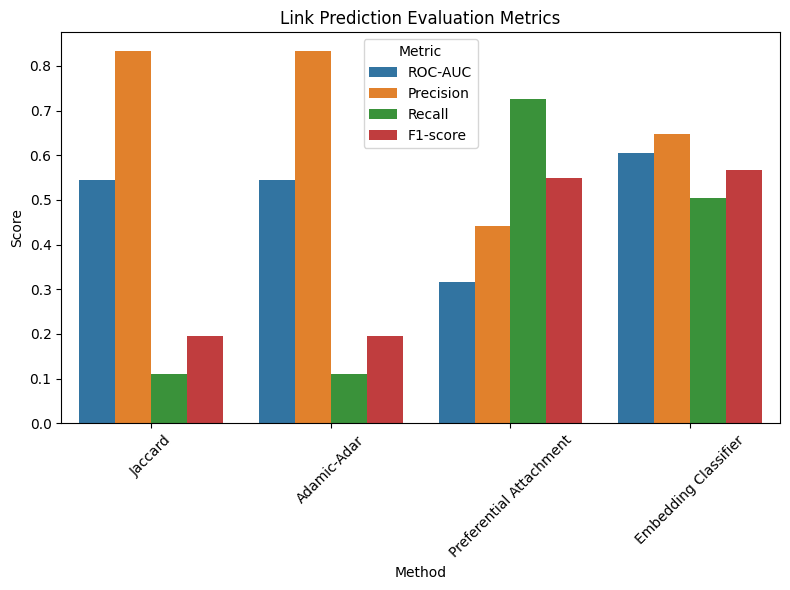

In [ ]:
# Melt the DataFrame for easier plotting
df_melt = df_metrics.melt(id_vars='Method', var_name='Metric', value_name='Score')

plt.figure(figsize=(8, 6))
sns.barplot(x='Method', y='Score', hue='Metric', data=df_melt)
plt.title("Link Prediction Evaluation Metrics")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 7.2 Ranked List of New Links

In [244]:
# Generate Candidate Missing Edges using classifier probabilities
candidates = list(nx.non_edges(G))
classifier_candidates = []
for (u, v) in candidates:
    try:
        feature = create_feature_vector(u, v, model)
        prob = clf.predict_proba([feature])[0, 1]
        classifier_candidates.append((u, v, prob))
    except KeyError:
        # Skip candidate if embedding is missing for either node
        continue

# Sort Candidate Edges by Classifier Probability
sorted_candidates = sorted(classifier_candidates, key=lambda x: x[2], reverse=True)
top_k = 25
top_candidates = sorted_candidates[:top_k]

print("\nTop {} candidate missing edges based on classifier probability:".format(top_k))
for u, v, prob in top_candidates:
    name_u = G.nodes[u].get("stop_name", u)
    name_v = G.nodes[v].get("stop_name", v)
    print(f"Edge {u} ({name_u}) - {v} ({name_v}), probability = {prob:.4f}")




Top 25 candidate missing edges based on classifier probability:
Edge IDFM:60247 (Brétigny) - IDFM:73042 (Champigny), probability = 0.9999
Edge IDFM:60247 (Brétigny) - IDFM:72929 (Sucy - Bonneuil), probability = 0.9999
Edge IDFM:59948 (Marolles-en-Hurepoix) - IDFM:73042 (Champigny), probability = 0.9999
Edge IDFM:59948 (Marolles-en-Hurepoix) - IDFM:72929 (Sucy - Bonneuil), probability = 0.9999
Edge IDFM:59948 (Marolles-en-Hurepoix) - IDFM:71519 (Anatole France), probability = 0.9999
Edge IDFM:59948 (Marolles-en-Hurepoix) - IDFM:70393 (Saint-Maur - Créteil), probability = 0.9999
Edge IDFM:60247 (Brétigny) - IDFM:72057 (Pont de Levallois - Bécon), probability = 0.9999
Edge IDFM:59948 (Marolles-en-Hurepoix) - IDFM:72057 (Pont de Levallois - Bécon), probability = 0.9999
Edge IDFM:60247 (Brétigny) - IDFM:60124 (Villabé), probability = 0.9999
Edge IDFM:59948 (Marolles-en-Hurepoix) - IDFM:60124 (Villabé), probability = 0.9999
Edge IDFM:60422 (Le Bras de Fer) - IDFM:73042 (Champigny), probabil

In [245]:
# Network Metrics Analysis Before & After Adding Top-k Predicted Links 
def compute_network_metrics(graph):
    metrics = {}
    try:
        metrics["avg_path_length"] = nx.average_shortest_path_length(graph)
    except nx.NetworkXError:
        # If graph is not connected, compute for the largest connected component
        largest_cc = max(nx.connected_components(graph), key=len)
        subgraph = graph.subgraph(largest_cc)
        metrics["avg_path_length"] = nx.average_shortest_path_length(subgraph)
    metrics["avg_clustering"] = nx.average_clustering(graph)
    btwn = nx.betweenness_centrality(graph)
    metrics["avg_betweenness"] = np.mean(list(btwn.values()))
    metrics["efficiency"] = nx.global_efficiency(graph)
    return metrics

# Compute metrics on the original graph
metrics_before = compute_network_metrics(G)
print("\nNetwork Metrics BEFORE adding predicted links:")
for key, value in metrics_before.items():
    print(f"{key}: {value:.4f}")

# Create a copy of G to add new edges
G_new = G.copy()

# Add top-k predicted missing edges to G_new
# (We no longer skip edges even if they share a line.)
for u, v, prob in top_candidates:
    # Always add the new edge, e.g. with default weight of 60 seconds
    G_new.add_edge(u, v, weight=60, type="predicted", line="predicted")

# Compute metrics on the updated graph
metrics_after = compute_network_metrics(G_new)
print("\nNetwork Metrics AFTER adding predicted links:")
for key, value in metrics_after.items():
    print(f"{key}: {value:.4f}")


Network Metrics BEFORE adding predicted links:
avg_path_length: 11.1613
avg_clustering: 0.0575
avg_betweenness: 0.0187
efficiency: 0.1142

Network Metrics AFTER adding predicted links:
avg_path_length: 10.7760
avg_clustering: 0.0614
avg_betweenness: 0.0180
efficiency: 0.1184
